In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$F_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta^\top x$$

# Generate Communication Network

In [2]:
n = 10  # Number of nodes
n_i = 10  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

informed_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    informed_dict[node] = {'informed': N[node]}  
    
nx.set_node_attributes(G, informed_dict)  # set attributes for each node

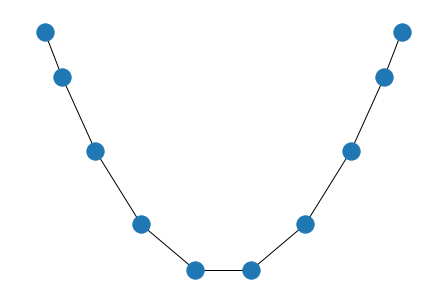

In [3]:
nx.draw_spectral(G)

# Problem Parameters

In [4]:
theta_0 = np.ones((n,n))-(n+1)*np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[ -9.9553641    0.89361035   0.79861576   0.84623195   0.97165595
    0.90994      0.95491553   0.86738777   0.80604829   0.88166184]
 [  0.97219072  -9.99349439   1.10586811   0.90197565   1.08293532
    1.18985195   0.96998853   1.11109715   0.94724034   0.98297602]
 [  0.98102865   0.95601207 -10.13190195   1.0739758    0.9369119
    0.95486012   1.1741362    0.99910026   1.02666818   1.01739512]
 [  1.20049947   1.01336023   1.00245884 -10.14196787   0.89922981
    1.07022229   1.21436886   1.0693985    0.97724118   1.08401239]
 [  1.16997801   1.04354962   1.09257641   0.95357597 -10.04713832
    0.90497337   1.33521136   0.91604163   0.93417946   0.90965737]
 [  0.99183471   0.96878206   0.93656033   1.04030925   1.02830884
  -10.05128954   1.00830644   1.00787151   1.12702915   1.00866644]
 [  0.97463807   1.12986911   0.97816102   0.95383707   0.88180075
    1.18073556  -9.84127186   1.11221995   0.96031554   0.81126031]
 [  1.00582102   1.11484114   1.0576792    1.05134751   

# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):
    return 2*np.dot(theta,x) + xi

def grad_total_revenue(x,theta,xi):
    return 

# Centralized GD

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 49331.40it/s]


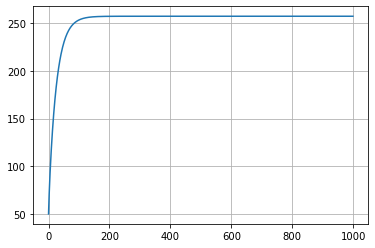

[4.64866014 5.26263165 5.13175284 5.30733678 5.22700011 5.16714609
 5.20276832 5.18161608 5.14272725 5.21540725]


In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = 10  # Set maximum price
rev = []
x_hist = []
iterations = 1000

# Run centralized GD
for i in trange(iterations):
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information